In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import colorcet

In [2]:
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{siunitx}\sisetup{detect-all}\usepackage{sansmath}\sansmath')

In [3]:
def fit(x, a, b, c, d):
    zenith = np.pi / 2 - x[0]
    az = x[1]
    return a * np.tan(b * zenith) * np.cos(az - c) + d
fit_results = np.load('../result-data/fit-results.npy')

In [4]:
class MidpointNormalize(matplotlib.colors.Normalize):
    # From https://stackoverflow.com/a/50003503
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        matplotlib.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return np.ma.masked_array(np.interp(value, x, y))

In [5]:
alts = np.linspace(90, 15, 1501)
az = np.linspace(0, 360, 7201)
out = np.array([[fit((alt, a), *fit_results) for a in np.deg2rad(az)] for alt in np.deg2rad(alts)])

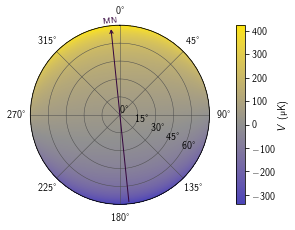

In [6]:
plt.figure(figsize=(4.4, 3.3))

ax = plt.subplot(1, 1, 1, projection='polar')
norm = MidpointNormalize(vmin=np.min(out)*1e6, vmax=np.max(out)*1e6, midpoint=0)
plt.pcolormesh(np.deg2rad(az), 90 - alts, out*1e6, cmap='cet_bjy', norm=norm, rasterized=True)
ax.set_yticks(np.arange(0, 90, 15))
# Zenith angle labels
ax.set_yticklabels(['\SI{0}{\degree}', '\SI{15}{\degree}', '\SI{30}{\degree}', '\SI{45}{\degree}', '\SI{60}{\degree}', ''])
ax.set_theta_zero_location('W', offset=-90)
ax.set_theta_direction(-1)
ax.set_rlabel_position(120)
ax.grid(b=True, which='major', color='0.3', linestyle='-', lw=0.5)
plt.colorbar(pad=0.1).set_label('\emph{V} (\si{\micro\kelvin})')

color = 'xkcd:dark purple'
plt.annotate('MN', xy=(np.deg2rad(174.1), 75), xytext=(np.deg2rad(354.1), 79.5), arrowprops=dict(arrowstyle='<-', capstyle='butt', joinstyle='miter', color=color), horizontalalignment='center', verticalalignment='center', fontsize=9, color=color, rotation=5.9)

plt.tight_layout()
plt.savefig('../result-data/sky-plot.pdf', dpi=300)